In [3]:
from google.colab import files
uploaded = files.upload()

Saving CR_train.csv to CR_train.csv
Saving CR_test.csv to CR_test.csv


## Data Preprocessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load the datasets
train_data = pd.read_csv('CR_train.csv', encoding='cp1252')
test_data = pd.read_csv('CR_test.csv', encoding='cp1252')

# Combine the datasets to ensure all categories are encoded correctly
combined_data = pd.concat([train_data, test_data], axis=0)

# Check for missing values
print("Missing values in training data:\n", train_data.isnull().sum())
print("Missing values in test data:\n", test_data.isnull().sum())

# Encode categorical variables
categorical_columns = combined_data.select_dtypes(include=['object']).columns
le = LabelEncoder()

for col in categorical_columns:
    combined_data[col] = le.fit_transform(combined_data[col])

# Separate the data back into train and test sets
train_data = combined_data.iloc[:len(train_data), :]
test_data = combined_data.iloc[len(train_data):, :]

# Separate features and target variable
X = combined_data.drop('credit_card_default', axis=1)
y = combined_data['credit_card_default']

# Handle missing values in the target variable *before* splitting. The datasets were checked for missing values, and missing values in the target variable were filled with the mode.
y.fillna(y.mode()[0] if not y.mode().empty else 0, inplace=True)

Missing values in training data:
 customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64
Missing values in test data:
 customer_id                  0
name                         0
age                          0
gender                       0
owns_car                   132
owns_house                   0
no_of_children             190
net_yearly_income            0
no_of_days_employed        105
occupation_type              0
total_family_members    

# Stratified Sampling
Stratified sampling was performed to ensure that both classes are represented in the training and test sets.

In [7]:
# Perform stratified sampling to ensure both classes are represented in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Feature Scaling
Feature scaling was applied to the datasets to ensure that all features contribute equally to the model training.

In [8]:
# Handle missing values in features
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Training and Evaluation
Logistic Regression

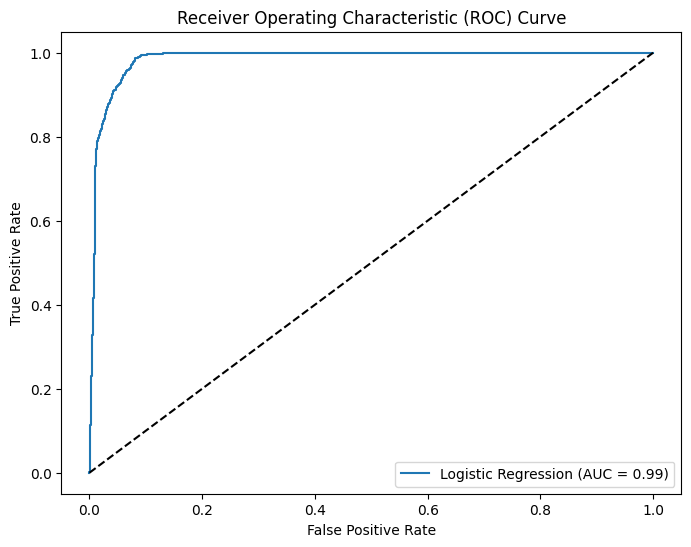

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     10644
         1.0       0.83      0.74      0.78       739

    accuracy                           0.97     11383
   macro avg       0.90      0.87      0.88     11383
weighted avg       0.97      0.97      0.97     11383



In [11]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# Initialize and train the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test)
pd_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC AUC and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pd_log_reg)
roc_auc = roc_auc_score(y_test, pd_log_reg)

# Define plot_roc_curve function if it doesn't exist
def plot_roc_curve(fpr, tpr, model_name, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call plot_roc_curve with auc_score
plot_roc_curve(fpr, tpr, 'Logistic Regression', roc_auc)

# Print classification report
print(classification_report(y_test, y_pred_log_reg)) # Call classification_report within print()

# Decision Tree

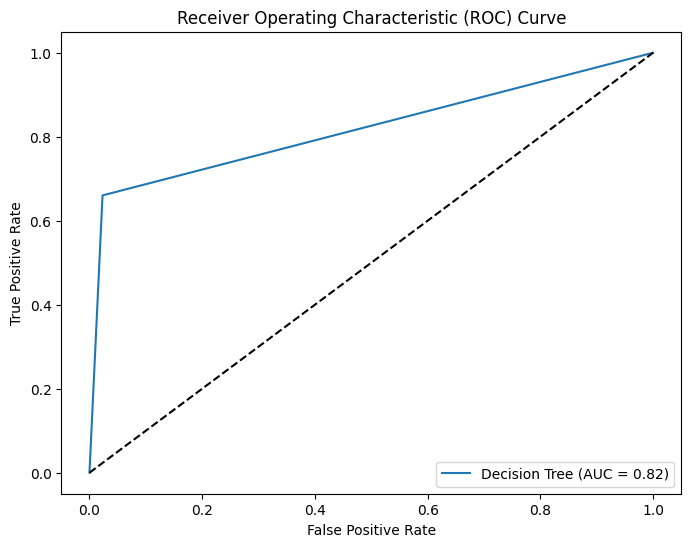

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     10644
         1.0       0.66      0.66      0.66       739

    accuracy                           0.96     11383
   macro avg       0.82      0.82      0.82     11383
weighted avg       0.96      0.96      0.96     11383



In [14]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt.predict(X_test)
pd_dt = dt.predict_proba(X_test)[:, 1]

# Calculate ROC AUC and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pd_dt)
roc_auc = roc_auc_score(y_test, pd_dt)
plot_roc_curve(fpr, tpr, 'Decision Tree', roc_auc) # Pass the calculated roc_auc value

# Print classification report
print(classification_report(y_test, y_pred_dt)) # Use print() with classification_report

# Random Forest

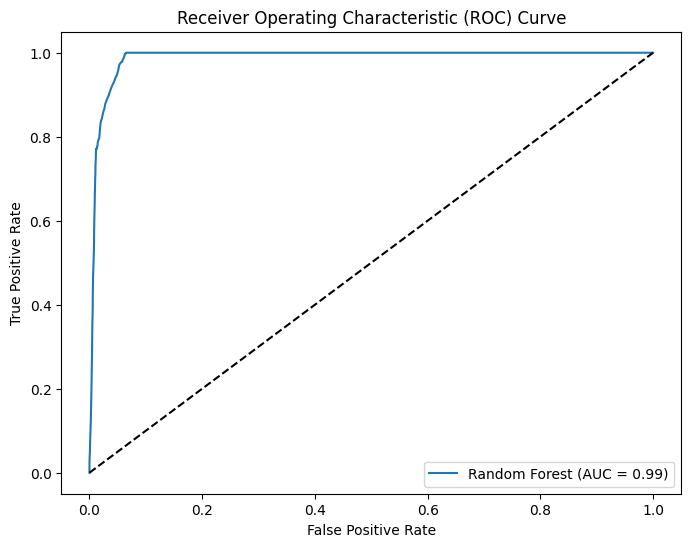

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     10644
         1.0       0.82      0.77      0.79       739

    accuracy                           0.97     11383
   macro avg       0.90      0.88      0.89     11383
weighted avg       0.97      0.97      0.97     11383



In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
pd_rf = rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pd_rf)
roc_auc = roc_auc_score(y_test, pd_rf)
plot_roc_curve(fpr, tpr, 'Random Forest', roc_auc) # Pass roc_auc to the function

# Print classification report
print(classification_report(y_test, y_pred_rf)) # Use the correct function name

# XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:25:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


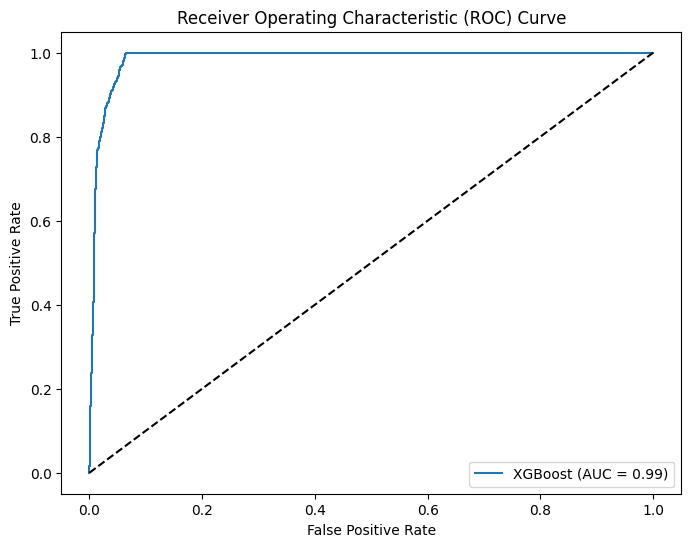

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10644
         1.0       0.79      0.77      0.78       739

    accuracy                           0.97     11383
   macro avg       0.89      0.88      0.88     11383
weighted avg       0.97      0.97      0.97     11383



In [21]:
import xgboost as xgb
from sklearn.metrics import classification_report # Import the necessary function

# Initialize and train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
pd_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pd_xgb)
roc_auc = roc_auc_score(y_test, pd_xgb)
plot_roc_curve(fpr, tpr, 'XGBoost', roc_auc) # Pass the calculated roc_auc value to the function

# Print classification report
print(classification_report(y_test, y_pred_xgb)) # Use the correct function and print its output

# K-Nearest Neaighbors(KNN)

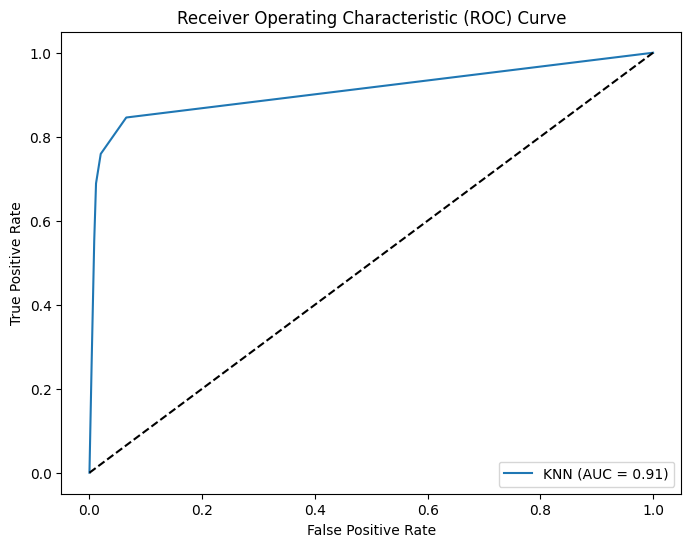

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10644
         1.0       0.80      0.69      0.74       739

    accuracy                           0.97     11383
   macro avg       0.89      0.84      0.86     11383
weighted avg       0.97      0.97      0.97     11383



In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report # Import classification_report

# Initialize and train the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
pd_knn = knn.predict_proba(X_test)[:, 1]

# Calculate ROC AUC and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pd_knn)
roc_auc = roc_auc_score(y_test, pd_knn)
plot_roc_curve(fpr, tpr, 'KNN', roc_auc) # Pass the calculated roc_auc value

# Print classification report
print(classification_report(y_test, y_pred_knn)) # Use the correct function name and print output

# Model Performance Comparison
# ROC Curve
The ROC curves for the various models are plotted to visualize the trade-off between true positive rate and false positive rate

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:29:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


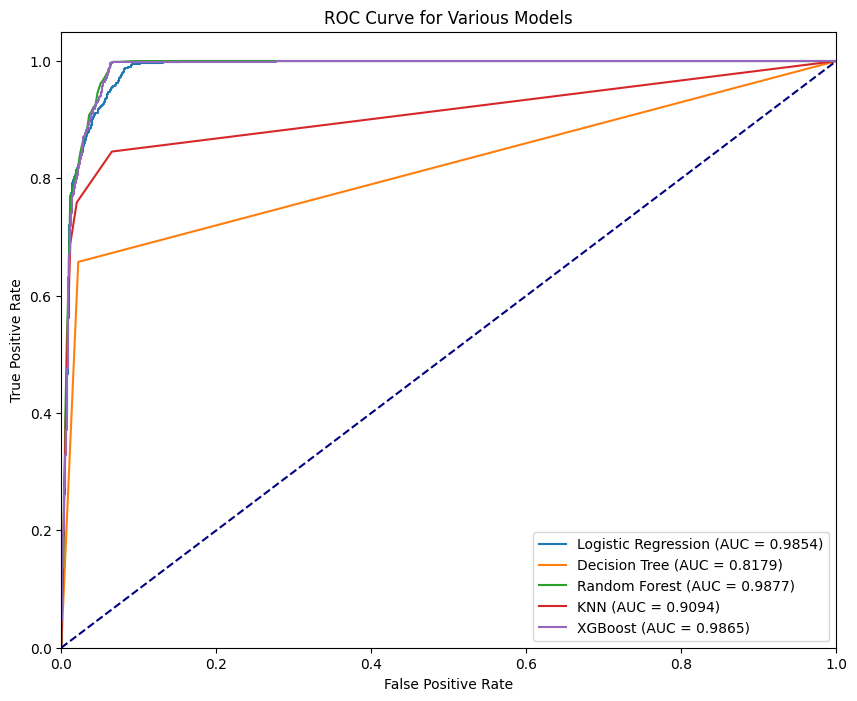

In [27]:
# Initialize results dictionary
results = {
    'Model': [],
    'Accuracy': [],
    'ROC AUC': []
}

# Define function to plot ROC curve
def plot_roc_curve(fpr, tpr, model_name, auc_score):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')

# Define function to evaluate model and collect results
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)

    plot_roc_curve(fpr, tpr, model_name, roc_auc)

    return accuracy, roc_auc

# Evaluate models
models = [
    (LogisticRegression(), "Logistic Regression"),
    (DecisionTreeClassifier(), "Decision Tree"),
    (RandomForestClassifier(n_estimators=100), "Random Forest"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost")
]

# Plotting the ROC curves for all models
plt.figure(figsize=(10, 8))
for model, name in models:
    evaluate_model(model, name)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend(loc="lower right")
plt.show()


# Summary Table
The performance metrics for the various models are summarized in a table.

In [28]:
# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_df)


                 Model  Accuracy   ROC AUC
2        Random Forest  0.974084  0.987664
0  Logistic Regression  0.973030  0.985352
4              XGBoost  0.971624  0.986526
3                  KNN  0.968901  0.909352
1        Decision Tree  0.957305  0.817878


# Analysis and Conclusion
# Analysis
The performance of various machine learning models was evaluated based on accuracy and ROC AUC scores. The ROC curves provide a visual representation of the trade-off between true positive rate and false positive rate for each model